In [1]:
import numpy as np
import pandas as pd

from skimage import io
from skimage.filters import threshold_otsu, gaussian
from skimage import measure
from skimage.transform import resize
from skimage.morphology import binary_dilation, ball

import os
from matplotlib import pyplot as plt
import pandas as pd
import napari
import tifffile
# from threadpoolctl import threadpool_limits

from scipy import spatial
from scipy import ndimage as ndi
from scipy.ndimage import map_coordinates
from scipy.integrate import solve_ivp
from scipy import interpolate

from sklearn.preprocessing import normalize
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import manifold

# from sklearn_extra.cluster import KMedoids

import zarr

import pydeform.sitk_api as pydeform
import itertools
import ray
from tqdm import tqdm
import ants
import SimpleITK as sitk

from vispy import color
from vispy.color import Colormap

import pickle
import xarray as xr

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [126]:
import importlib
from morphotrack import trace
import morphotrack.variables
import morphotrack.points
import morphotrack.track
importlib.reload(morphotrack.variables)

# num_cpus=48
# ray.init(num_cpus=num_cpus, ignore_reinit_error=True)
turbo_dark = Colormap(morphotrack.variables.turbo_list)

In [3]:
io_directory = '/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis'
asma_downscale = np.load(os.path.join(io_directory,'vessel.npy'))

# load autofluorescence/nuclei for segmentation
autofl_zarr = zarr.open('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/ch488_10um.zarr',mode='r')
autofl = autofl_zarr['0'][:]
voxel_size = [10, 10, 10]

autofl_filled = autofl

In [4]:
def seed_selection(seeds, normals, flow_on_seeds, n_clusters=6, cluster_selection='min'):
    """
    Select the seeds on the surface of interest. 
    """
    # Calculate dot product of normal vector and flows
    seeds_dot_product = np.sum(normals*flow_on_seeds, axis=1) # This will return the dot product.

    # Start clusterings
    features = np.concatenate((seeds,normals,seeds_dot_product[...,np.newaxis]),axis=1) # Make feature matrix, xyz coordinates + normal vectors + dot products
    scaler = StandardScaler().fit(features)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaler.transform(features)) # Clustering 

    # Extract seeds in the cluster of interest.
    if cluster_selection=='min':
        cluster_of_interest = np.argmin(kmeans.cluster_centers_[:,-1]) # Minimum in this case. Could be maximum depending on the orientation of the tissue or guide vector.
    elif cluster_selection=='max':
        cluster_of_interest = np.argmax(kmeans.cluster_centers_[:,-1])
    else:
        print("error")
        return None
    return (kmeans.labels_==cluster_of_interest)

In [5]:
# read cellular coordinate
cells_info = pd.read_csv('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/coord_centroids.csv',index_col=0) # the unit is original voxel.
scaling_factor = np.asarray([3,0.65,0.65])
cell_coords = cells_info.loc[:,['centroid-0','centroid-1','centroid-2']] * scaling_factor / 10# convert unit to 10 um for consistency
cell_coords = cell_coords.to_numpy()

# make kdTree of the nuclei
coords_tree = spatial.KDTree(cell_coords)

In [6]:
%%time
### selection of the outer most cells.
import alphashape
import networkx as nx

# convex hull is not successful. Try alpha shape instead.
# 750,000 takes ~7 min.
downsample = 10
alpha = alphashape.alphashape(cell_coords[::downsample,:], 0.1)

# use network to select the largest point clouds
groups = nx.connected_components(alpha.vertex_adjacency_graph)
groups = list(groups)
# select the largest point clouds
idx = groups[np.asarray([len(c) for c in groups]).argmax()]
ver = np.asarray(alpha.vertices[tuple(idx),:])
nor = np.asarray(alpha.vertex_normals[tuple(idx),:])

# check the selected vertices
viewer = napari.Viewer()
viewer.add_points(
    ver,
    size=2,
    face_color = 'white',
    edge_width=0,
    symbol='disc',
)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



CPU times: user 6min 18s, sys: 2.19 s, total: 6min 20s
Wall time: 6min 15s


In [7]:
filename = '/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis/model.pkl'
clf = pickle.load(open(filename, 'rb'))

In [8]:
norm_flow_on_coordinate = morphotrack.points.get_norm_flow_on_coordinate(clf.degree, clf)

In [9]:
selection = seed_selection(ver, nor, norm_flow_on_coordinate(ver), n_clusters=3)
points = ver[selection]

# np.save('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis/surface_points.npy',points)
# points = np.load('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis/surface_points.npy')

viewer = napari.Viewer()
viewer.add_points(
    points,
    size=2,
    face_color = 'white',
    edge_width=0,
    symbol='disc',
)

# seeds_df = pd.DataFrame(ver[selection], columns=['x0','x1','x2'])


/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Points layer 'points' at 0x7fac86978a60>

## Seeding and extending

In [13]:
# %%time
# # Segmentation of the image
# autofl_gauss = gaussian(autofl_filled,sigma=10,mode='nearest',preserve_range=True)
# background_val = 300
# segmented_tissue = (autofl_gauss>background_val)

CPU times: user 14.1 s, sys: 540 ms, total: 14.6 s
Wall time: 14.6 s


In [91]:
polynomial_vectorfield = morphotrack.track.polynomial_vectorfield_generator(clf.coef_, clf.degree)

In [92]:
tracker = morphotrack.track.FieldTracker(polynomial_vectorfield, points)

In [93]:
t_start = 0
t_end = 500
tracker.solve_ode(t_start,t_end)

(par_solve_ode pid=2376873) 
(par_solve_ode pid=2376965) 


In [13]:
def fill_value_in_range(array, index_array, value=255.):
    '''
    The function fill the value in a given array using indexing array. 
    The indexing array can have the index outside of the given array. The position indicated by index array is filled with the value.
    The outside index will be disregarded. 
    array: numpy array to be filled with value.
    index_array: numpy array for indexing. Each column has the position of the array to be filled.
    value: value to be filled. int or numpy array with the size of column number in index_array.
    '''
    dim = array.ndim
    # Select indices within the range of the array.
    column_to_select = np.all(
        [np.all([index_array[i,:] >= 0 for i in range(dim)], axis=0), np.all([index_array[i,:] < (array.shape[i] - 0.5) for i in range(dim)], axis=0)],
        axis=0
    )
    select_idx = index_array[:,column_to_select]
    select_idx = np.around(select_idx).astype(int)
    
    # Fill the value in the array.
    if isinstance(value,np.ndarray):
        array[tuple([select_idx[i,:] for i in range(dim)])] = value[column_to_select]
    else:
        array[tuple([select_idx[i,:] for i in range(dim)])] = value
    return array

In [14]:
seed_choice = tracker.t_positions.track.data

In [27]:
# Export image if necessary
from vispy.color import Colormap
label_r = Colormap([[1.0, 1.0, 1.0, 0.0], [1.0, 0.0, 0.0, 1.0]])
label_g = Colormap([[1.0, 1.0, 1.0, 0.0], [0.0, 1.0, 0.0, 1.0]])
label_b = Colormap([[1.0, 1.0, 1.0, 0.0], [0.0, 0.0, 1.0, 1.0]])
palette = [label_r,label_g,label_b]
directions = ['red','green','blue']
if True:
    flow_img = np.zeros(asma_downscale.shape+(3,))
    for seed_num in seed_choice[::5]:
        
        position = tracker.t_positions.isel(track=seed_num).data.T
        position[np.isnan(position)] = 0
        for i in range(3):
            flow_vector = abs(norm_flow_on_coordinate(position.T)[:,i])
            flow_img[...,i] = fill_value_in_range(flow_img[...,i],position,flow_vector)
    for i in range(3):
        flow_img[...,i] = flow_img[...,i]*segmented_tissue
    viewer = napari.Viewer()
    viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='sma', colormap='gray', blending='additive') # [100:250,...]
    for i in range(3):
        viewer.add_image(flow_img[...,i], contrast_limits=[0,1], rgb=False, name=directions[i], colormap=palette[i], blending='translucent')
    # viewer.add_image(flow_img, rgb=True, name='flow', blending='additive')
    viewer.add_image(segmented_tissue, contrast_limits=[0,2], rgb=False, name='mask', colormap='cyan', blending='additive', multiscale=False, visible=False)

In [33]:
# seeds_df['sel5'] = False # Trajectory is long enough for alignment analysis.
# min_length = 200 # minimum 3
# for seed_num in seed_choice:
#     virtual_rg = virtual_rgs[seed_num]
#     if virtual_rg.trajectory.inloc.sum() > min_length:
#         seeds_df.loc[seed_num,'sel5'] = True

In [123]:
import morphotrack.points
import morphotrack.track
importlib.reload(morphotrack.points)
importlib.reload(morphotrack.track)

<module 'morphotrack.track' from '/home/tmurakami/src/morphotrack/morphotrack/track.py'>

In [ ]:
# tes1 = tracker.t_positions.stack(pos=['time', 'track']).T
tes2 = tracker.apply_function_to_position(norm_flow_on_coordinate)

In [ ]:
def count_around_position(coords_tree, half_thickness, radius):
    def f(arr1, arr2):
        a,_,_ = morphotrack.points.count_around_position(arr1, arr2, coords_tree, half_thickness, radius=radius)
        return a
    return f

In [ ]:
%%time
half_thickness = 2.5 # * 10 micrometer. half of the thickness
radius = 10 # * 10 micrometer

tes3 = tracker.apply_function_to_position_with_array(count_around_position(coords_tree, half_thickness, radius),tes2)

In [ ]:
viewer = napari.Viewer()
viewer.add_image(tes3.data.squeeze())


In [36]:
# def conv_along_line(half_thickness, positions, flow, coords_tree, radius=20, size=None):
#     # get coordinates
#     coords = coords_tree.data
#     # get index of the neighbors. idx is an array of lists. 
#     indices = coords_tree.query_ball_point(positions, r=radius)
    
#     coords_in_thickness = []
#     column_sum = []
#     idx_in_thickness = []
    
#     # convert index to the xyz coordinate. to each array element (i.e. list), convert to coord.
#     for i, idx in enumerate(indices.tolist()):
#         neighbor_coords = coords[idx,:]
#         in_thickness, subidx = isin_thickness(half_thickness, positions[i,:],flow[i,:], neighbor_coords)
#         coords_in_thickness.append(in_thickness)
#         column_sum.append(in_thickness.size)
#         idx_in_thickness.append(np.asarray(idx)[subidx])
    
#     column_sum = np.asarray(column_sum)
#     if size is not None:
#         column_sum = np.pad(column_sum, (0, size-column_sum.size), 'constant', constant_values=(0, 0)) # pad to the size
    
#     return column_sum, idx_in_thickness, coords_in_thickness

In [37]:
# def get_unique_number(list_of_array):
#     if len(list_of_array) == 0:
#         sequence = np.empty(0, dtype=np.int64)
#     else:
#         sequence = np.concatenate(list_of_array, axis=0)
#         sequence = sequence.astype(np.int64)
#     unique_number = np.unique(sequence)
#     return unique_number

In [40]:
def position_on_circunference(radius, n_points=8, dim=3):
    """ 
    n_points control the number of the points on circunference.
    """
    theta = np.arange(0, 2*np.pi, 2*np.pi/n_points)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)

    position = np.stack((y, x))
    if dim == 3:
        position = np.vstack((np.zeros_like(x),position))
    
    return position.T

In [41]:
def get_orthonogals(k,x=np.asarray([0.0,1.0,0.0])):
    """
    k: 2darray. nx3 
    Assume input vector k to be normalized
    """
    x = x - k.dot(x)[:,None] * k       # make x orthogonal to k
    x = x / np.linalg.norm(x,axis=1)[:,None]  # normalize it

    y = np.cross(k, x)
    
    return k, x, y

In [42]:
def rotate_with_normals(coord, vectors):
    """
    rotate agianst normal. (0,0,0) is used as the origin of the rotation
        coord: 2darray. ix3. coordinates to be rotated. 
        vectors: 2darray. jx3. j is a number of the normal vectors. 
    return
        points: 3darray. ixjx3. rotated position of coordinates for each normal vector.  
    """
    M = get_orthonogals(vectors)

    points = np.einsum('ij,jkl->ikl', coord, np.asarray(M)) # [measurement point, position in line, xyz coordinate]
    #points = np.moveaxis(points,1,0)

    return points

In [ ]:
def get_local_flux(positions, vector_field, radius, dim=3, n_points=8):
    """
    positions: ndarray
    vector_field: function. return vector for each position
    radius: int
    """
    flow = vector_field(positions)
    # generate measuring points. circles around position
    points_on_cicle = position_on_circunference(radius, n_points=n_points, dim=dim)
    rotated_points = rotate_with_normals(points_on_cicle, flow)
    measuring_point = rotated_points + positions 
    
    # calculate local flux
    temp = vector_field(measuring_point.reshape(-1, measuring_point.shape[-1]))
    vectors_on_points = temp.reshape(measuring_point.shape) # get vectors on measuring points
    local_flux = np.einsum('ijk,ijk->j', vectors_on_points, rotated_points/radius) / points_on_cicle.shape[0]
    
    return local_flux

In [43]:
# def get_gradient_func(coeff, ij_powers):
#     grad_coeff =  np.asarray([ij_powers[:,i] * coeff for i in range(3)])
#     def a(w):
#         element = []
#         for i in range(3):
#             powers = ij_powers.copy()
#             diff = powers[:,i]-1
#             powers[:,i] = diff
#             powers[powers<0] = 0  # to avoid an error
#             element.append(polynomial_eq(w,list(grad_coeff[i]),powers))
#         return np.asarray(element)
#     return a 

# def get_divergence_func(coeffs, ij_powers):
#     """
#     coeffs: coefficients of the polynomial for each element of a vector
#     """
#     div_coeffs = np.asarray([ij_powers[:,i] * coeffs[i,:] for i in range(3)])
#     def a(w):
#         div = 0
#         for i in range(3):
#             powers = ij_powers.copy()
#             powers[:,i] = powers[:,i] - 1 
#             powers[powers<0] = 0 # to avoid an error
#             div += polynomial_eq(w.T, div_coeffs[i,:], powers)
#         return div
#     return a

In [145]:
from sklearn.metrics import mutual_info_score

#https://stackoverflow.com/questions/20491028/optimal-way-to-compute-pairwise-mutual-information-using-numpy
def mutual_information(s1, s2, bins=10):
    """
    """
    hist = np.histogram2d(s1, s2, bins)[0]
    mi = mutual_info_score(None,None,contingency=hist)
    return mi

In [146]:
def make_displacement_map(position_arr):
    coords = np.meshgrid(*[range(x) for x in position_arr.shape], indexing='ij')
    coords = np.array(coords).astype(np.int16)
    coords[0,:,:] = position_arr
    
    return coords

In [55]:
# # convolve the cell count along the growthline.
# # prepare column cell number convolution
# half_thickness = 2.5 # * 10 micrometer. half of the thickness
# radius = 10 # * 10 micrometer
# # column cell number convolution
# column_conv_np_ = np.zeros((t_end, len(seed_choice)))
# for i, seed_num in tqdm(list(enumerate(seed_choice))):
#     # virtual_rg = virtual_rgs[seed_num]

#     # get position of a line as 1D array.
#     positions = tracker.t_positions.isel(track=seed_num).data
#     positions = positions[~np.isnan(positions).any(axis=1),:] # drop nan
#     # get flow on the postion
#     flow = norm_flow_on_coordinate(positions) # flow is normalized
    
#     # count the number of cells in a disk along the line
#     column_conv_np_[:,i], _, _ = morphotrack.points.count_around_position(positions, flow, coords_tree, half_thickness, radius, t_end)
    
# column_conv = pd.DataFrame(column_conv_np_.T,index=seed_choice)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 8175/8175 [09:15<00:00, 14.71it/s]


In [ ]:
'''The scripts below is extremely ugly. '''
'''manihold 2D & 1D'''

In [141]:
std_idx = morphotrack.points.pick_median_nearest_point(points,1)

In [ ]:
# To avoid picking short fibers as a representitive, limit the area around median center point.
# Select the seeds for analysis.

# Find seeds around a median point.
# center_seeds = seeds_df2.iloc[pick_median_nearest_point(seeds_df2,20),:] # Consider voxel size.

In [322]:
# %%time
# # do 2D isomap
# X0 = seeds_df.iloc[:,0:3]
# # X0_sampled = X0.sample(frac=1, replace=False, random_state=1) # downsample for faster computation
# iso = manifold.Isomap(n_neighbors=20, n_components=2, n_jobs=-1)
# iso.fit(X0)
# manifold_2D = iso.transform(X0)

# translate_manifold2D = manifold_2D - manifold_2D.min(axis=0)[np.newaxis,:]
# translate_manifold2D_df = pd.DataFrame(pd.DataFrame(translate_manifold2D,index=seeds_df.index),index=seeds_df.index)

CPU times: user 45.7 s, sys: 12.1 s, total: 57.8 s
Wall time: 37.4 s


In [610]:
# # manually label the cells on surface using 2D plot

# # https://napari.org/api/napari.view_layers.html#napari.view_layers.view_points
# viewer = napari.Viewer()
# points = viewer.add_points(
#     translate_manifold2D,
#     size=2,
#     face_color = 'white',
#     edge_width=0,
#     symbol='disc',
# )
# labels = viewer.add_labels(np.zeros(translate_manifold2D.max(axis=0).astype(int),int), name='label')

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [611]:
# # Check the labeled positions in 3D

# label_coords = np.asarray(np.nonzero(labels.data)).astype(int).T

# # a bit of trick. use pandas to choose the points where they belong to the manual label.
# elem = pd.DataFrame(translate_manifold2D.astype(int),index=seeds_df.index).reset_index().merge(pd.DataFrame(label_coords),how='inner',on=[0,1]).set_index('index')

# cond1 = seeds_df.iloc[:,4:].all(axis=1)
# cond2 = seeds_df.index.isin(elem.index)

# # visualize the label in 3D
# viewer = napari.Viewer()
# points = viewer.add_points(
#     seeds_df.iloc[:,0:3][cond1 * cond2],
#     size=2,
#     face_color = 'white',
#     edge_width=0,
#     symbol='disc',
# )
# viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='green', blending='additive', multiscale=False)
# viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7faeaa816130>

In [48]:
# #seed_choice = seed_df[cond1*cond2].index.to_list()
# seed_choice = np.load('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis/selected_seed_num.npy')
# seed_choice = seed_choice.tolist()

## get 1d manifold for alignment

In [157]:
def isomap_wrapper(coordinate,n_neighbors=20, n_components=1, **kwargs):
    iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components, n_jobs=-1, **kwargs)
    iso.fit(coordinate)
    transformed_coordinate = iso.transform(coordinate).squeeze()
    return transformed_coordinate

In [158]:
tes_iso = isomap_wrapper(tracker.seeds)

In [159]:
np.argsort(tes_iso,axis=0)

array([7604, 3302, 6797, ..., 1120, 4320, 5253])

In [160]:
# # reduce dimention to 1d for manual alignment
# # X0_selected = seeds_df.iloc[:,0:3][cond1 * cond2]
# X0_selected = seeds_df.iloc[:,0:3].loc[seed_choice,:]#[cond1 * cond2]
# iso1d = manifold.Isomap(n_neighbors=20, n_components=1, n_jobs=-1) # change n_neighbors in case of error.
# iso1d.fit(X0_selected)
# manifold_1D = iso1d.transform(X0_selected)
# manifold_1D_df = pd.DataFrame(manifold_1D,index=seed_choice)#seeds_df.iloc[:,0:3][cond1 * cond2].index)
# # manifold_1D_df = manifold_1D_df.sort_values(0)

In [468]:
# seed_choice = manifold_1D_df.sort_values(0).index.to_list()
# # np.save(os.path.join(io_directory,'selected_seed_num.npy'), manifold_1D_df.sort_values(0).index.to_numpy())

In [53]:
# # visualize the label in 3D with color

# points_vis = seeds_df.iloc[:,0:3].reindex(seed_choice)
# color_mapper = manifold_1D_df.sort_values(0).to_numpy()
# color_vis = color.get_colormap('plasma').map((color_mapper-np.min(color_mapper)) / (np.max(color_mapper)-np.min(color_mapper)))

# viewer = napari.Viewer()
# points = viewer.add_points(
#     points_vis,
#     size=10,
#     face_color = color_vis,
#     edge_width=0,
#     symbol='disc',
# )
# viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray_r', blending='translucent', multiscale=False)
# viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)
# # viewer.theme = 'dark'

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f3a53153fa0>

In [469]:
# target = column_conv.reindex(seed_choice).to_numpy().T
# viewer0 = napari.Viewer()
# viewer0.add_image(target, rgb=False, name='original', colormap='gray', blending='additive', multiscale=False)

<Image layer 'original' at 0x7f39c5b55c40>

In [147]:
def aligner(standard, target, target2standard=None, settings=morphotrack.variables.settings):
    if target2standard is None:
        target2standard = np.meshgrid(*[range(x) for x in target.shape], indexing='ij')[0]
    displaced_tar2std = map_coordinates(target, make_displacement_map(target2standard), order=1, mode='constant') # transform fix for better interpretation.
    fix_itk = sitk.Cast(sitk.GetImageFromArray(displaced_tar2std[np.newaxis,:,:]),sitk.sitkFloat32) # itk convert numpy zyx to xyz
    mov_itk = sitk.Cast(sitk.GetImageFromArray(standard[np.newaxis,:,:]),sitk.sitkFloat32)
    
    df_sitk = pydeform.register(
        fix_itk,
        mov_itk,
        settings=settings,
        num_threads=60,
        use_gpu=True
    )

    displacement = sitk.GetArrayFromImage(df_sitk)[0,:,:,1] #pos = sitk.GetArrayFromImage(df_sitk)[:,0,0,2]

    coords = np.meshgrid(*[range(x) for x in displacement.shape], indexing='ij')
    coords = np.array(coords).astype(np.int16)
    coords[0,:,:] = coords[0,:,:]-displacement
    adjusted_target2standard = map_coordinates(target2standard, coords, order=1, mode='constant')
    
    return adjusted_target2standard

In [470]:
std_idx = 596
std_seed = seed_choice[std_idx]# selected_manihold_1D.iloc[std_idx,:].name
std_values = target[:,std_idx]
standard = np.repeat(std_values[:,np.newaxis],len(seed_choice),axis=1)
viewer0.add_image(standard, rgb=False, name='std', colormap='gray', blending='additive', multiscale=False)
labels = viewer0.add_labels(np.zeros_like(standard.astype(int)), name='labeling')

In [471]:
# make initial displacement using manual labels.
# labels_np = labels.data
labels_np = np.load('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis/layer_labels.npy')

initial_standard2target = np.zeros_like(standard)
initial_target2standard = np.zeros_like(standard)

std_landmark = np.array([0,22,33,108,126,266,standard.shape[0]]) # these are fixed numbers.
f = interpolate.interp1d(np.arange(std_values.size), std_values, bounds_error=False, fill_value='extrapolate') # f converts standard to target.

for line, seed_num in enumerate(seed_choice):
    # make landmarks_fix
    landmarks = std_landmark.copy()
    for i in range(1, std_landmark.size-1):
        positions = np.where(labels_np[:,line]==i)[0]
        if positions.size != 0:
            landmarks[i] = round(positions.mean())
        else:
            landmarks[i] = std_landmark[i]

    # make manually generated position shift
    coord = np.arange(labels_np.shape[0])
    pos_standard2target = interpolate.griddata(landmarks,std_landmark,xi=coord,method='linear')
    pos_target2standard = interpolate.griddata(std_landmark,landmarks,xi=coord,method='linear') # cubic distort the thing...
    initial_standard2target[:,line] = pos_standard2target
    initial_target2standard[:,line] = pos_target2standard
    
    values = column_conv.loc[seed_num,:].to_numpy()
    g = interpolate.interp1d(np.arange(values.size), values, bounds_error=False, fill_value='extrapolate') # g converts target to standard
    
    standard2target_shifted = f(pos_standard2target)
    target2standard_shifted = g(pos_target2standard) 


In [ ]:
### viewer2 = napari.Viewer()
initial_displaced_tar2std = map_coordinates(target, make_displacement_map(initial_target2standard), order=1, mode='constant') # transform fix for better interpretation.
initial_displaced_std2tar = map_coordinates(standard, make_displacement_map(initial_standard2target), order=1, mode='constant') # transform fix for better interpretation.
viewer2.add_image(initial_displaced_tar2std, rgb=False, name='manual_aligned', colormap='green', blending='additive', multiscale=False)
viewer2.add_image(initial_displaced_std2tar, rgb=False, name='manual_deformed', colormap='magenta', blending='additive', multiscale=False)
viewer2.add_image(standard, rgb=False, name='standard', colormap='gray', blending='additive', multiscale=False)

In [475]:
%%time
adjusted_target2standard = aligner(standard, target, initial_target2standard, settings)
adjusted_standard2target = aligner(target, standard, initial_standard2target, settings)

target2standard_df = pd.DataFrame(adjusted_target2standard.T,index=seed_choice)
standard2target_df = pd.DataFrame(adjusted_standard2target.T,index=seed_choice)

CPU times: user 2min 52s, sys: 42.1 s, total: 3min 34s
Wall time: 1min 28s


In [476]:
aligned = map_coordinates(target, make_displacement_map(adjusted_target2standard), order=1, mode='constant') # transform fix for better interpretation.
deformed = map_coordinates(standard, make_displacement_map(adjusted_standard2target), order=1, mode='constant') # transform fix for better interpretation.

viewer2 = napari.Viewer()
viewer2.add_image(standard, rgb=False, name='standard', colormap='gray', blending='additive', visible=False)
viewer2.add_image(aligned, rgb=False, name='aligned', colormap='green', blending='additive')
viewer2.add_image(deformed, rgb=False, name='deformed', colormap='blue', blending='additive')
viewer2.add_image(target, rgb=False, name='original', colormap='magenta', blending='additive')

<Image layer 'original' at 0x7f39caa46eb0>

In [844]:
from tslearn.metrics import dtw, dtw_path, ctw_path, dtw_path_limited_warping_length, soft_dtw_alignment
# import dtw

In [64]:
def local_duplicate(series, l):
    """
    input:
        series: 1d numpy (dim=n) array
        l: local window to duplicate. 
    return:
        (n+l)*(2l+1) 2d array
    """
    append_series = np.insert(series,0,[series[0]]*l)
    append_series = np.insert(append_series,-1,[append_series[-1]]*l)
    local_duplicated_series = np.array([append_series[i:-(l-i)] for i in range(l)])
    local_duplicated_series = local_duplicated_series.T
    
    return local_duplicated_series

In [65]:
def local_derivative(series, l):
    local_duplicated_series = local_duplicate(series, l)
    
    # trim the end of the matrix to make the size consistent.
    return np.diff(local_duplicated_series,axis=1)[:-l,:]
    

In [66]:
def filter_signal(signal, threshold=1e3):
    fourier = np.fft.rfft(signal)
    frequencies = np.fft.rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    
    fft_filtered_signal = np.fft.irfft(fourier)
    # pad to original size
    if fft_filtered_signal.size < signal.size:
        fft_filtered_signal = np.append(fft_filtered_signal,[fft_filtered_signal[-1]]*(signal.size-fft_filtered_signal.size))

    return fft_filtered_signal

In [67]:
def dtw_aligner(standard, target, l, fft_threshold=1e3, gamma=1):
    mtx, score = soft_dtw_alignment(
        local_derivative(filter_signal(standard, fft_threshold), l),
        local_derivative(filter_signal(target, fft_threshold), l),
        gamma=gamma
    )
    idx1 = np.argmax(mtx,axis=0)
    idx2 = np.argmax(mtx,axis=1)

    if idx1.size < target.size:
        idx1 = np.append(idx1,[idx1[-1]]*(target.size-idx1.size))

    if idx2.size < target.size:
        idx2 = np.append(idx2,[idx2[-1]]*(target.size-idx2.size))

    return idx1, idx2, score

In [68]:
def line_wise_dtw_aligner(standard, target, l, fft_threshold=1e3, gamma=1):
    
    standard2target = np.zeros_like(target)
    target2standard = np.zeros_like(target)
    score_ = np.zeros(target.shape[1])

    for line in tqdm(range(target.shape[1])):
        idx1, idx2, score = dtw_aligner(standard, target[:,line], l, fft_threshold=1e3, gamma=1)
        
        standard2target[:,line] = idx1
        target2standard[:,line] = idx2
        score_[line] = score
        
    return standard2target, target2standard, score_

In [477]:
def position2distance(positions):
    """
    positions: 2d array. Nx3.
    """
    diff = np.diff(positions,axis=0,prepend=0) # prepend to make the size consistent
    dist = np.linalg.norm(diff,2,axis=1)
    dist[0] = 0
    return dist

In [759]:
# find 3D coordinate and map back into the 3D image for better visualization. Quality check
pos_img = np.zeros_like(asma_downscale)
for i, seed_num in enumerate(seed_choice):
    virtual_rg = virtual_rgs[seed_num]
    positional_displacement = standard2target_df.loc[seed_num].to_numpy()
    positional_displacement[positional_displacement<0]=0 # clipping

    positions = virtual_rg.trajectory.ode_solution.y

    positional_displacement = positional_displacement[:positions.shape[1]]
    pos_img[tuple(positions.astype(int))] = positional_displacement
    
pos_img = pos_img * segmented_tissue.astype(np.uint16)
viewer = napari.Viewer()
viewer.add_image(pos_img, contrast_limits=[0,501], rgb=False, name='flow', colormap=turbo_dark, blending='additive', multiscale=False)
viewer.add_image(autofl, contrast_limits=[0,5000], rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False, visible=False)

<Image layer 'asma' at 0x7fabe168ab50>

In [70]:
def moving_average(x, w=10):
    return np.convolve(x, np.ones(w), 'same') / w

In [857]:
def cosine_similarity(a1, a2):
    return np.dot(a1,a2) / (np.linalg.norm(a1)*np.linalg.norm(a2))

In [478]:
# stretch map

virtual_rg_std = virtual_rgs[std_seed]
positions_std = virtual_rg_std.trajectory.ode_solution.y.T
window = 21
averaged_dist_std = moving_average(position2distance(positions_std),window)
f = interpolate.interp1d(np.arange(positions_std.shape[0]), positions_std.T, bounds_error=False)
logFC = []

for seed_num in seed_choice:
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    
    # get position in standard space. convert it to distance.
    interp_dist = position2distance(f(target2standard_df.loc[seed_num].to_numpy()).T)
    # get moving average to avoid log0 and division by zero.
    averaged_dist = moving_average(interp_dist,window)
    # averaged_dist_list.append(averaged_dist)
    logFC.append(np.log2(averaged_dist)-np.log2(averaged_dist_std))
    
logFC_df = pd.DataFrame(np.asarray(logFC),index=seed_choice)

/tmp/ipykernel_425507/570322235.py:19: RuntimeWarning:

divide by zero encountered in log2



In [504]:
viewer = napari.Viewer()
blue2red = Colormap([[0,0,1],[1,1,1],[1,0,0]])
viewer.add_image(logFC_df.to_numpy().T, contrast_limits=[-3,3], rgb=False, name='stretchiness', colormap=blue2red, blending='additive', multiscale=False)
viewer.add_image(aligned, rgb=False, name='aligned', colormap=color.colormap.MatplotlibColormap('pink_r'), blending='additive', multiscale=False)
viewer.add_image(target, rgb=False, name='original', colormap=color.colormap.MatplotlibColormap('PRGn'), blending='additive')

<Image layer 'original' at 0x7f39be24dc70>

In [506]:
viewer = napari.Viewer()
viewer.add_image(tes, rgb=False, name='stretchiness', colormap=color.colormap.MatplotlibColormap('pink_r'), blending='additive', multiscale=False)

<Image layer 'stretchiness' at 0x7f39c0a070a0>

In [480]:
# local flux map
local_flux = []
for i, seed_num in tqdm(list(enumerate(seed_choice))):
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    # append positions to be consisntent in size.
    positions = np.pad(positions,[(0,501-positions.shape[0]),(0,0)],mode='edge')
    # get local flux
    local_flux.append(get_local_flux(positions, norm_flow_on_coordinate, radius))
    
local_flux_df = pd.DataFrame(np.vstack(local_flux),index=seed_choice)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 807/807 [00:02<00:00, 292.33it/s]


In [481]:
# transform local_flux map for better interpretation
aligned_local_flux = map_coordinates(np.vstack(local_flux).T, make_displacement_map(adjusted_target2standard), order=1, mode='constant')
aligned_local_flux_df = pd.DataFrame(aligned_local_flux.T, index=seed_choice)

In [482]:
viewer = napari.Viewer()
viewer.add_image(aligned_local_flux, rgb=False, name='local_flux', colormap=blue2red, blending='additive', multiscale=False)
viewer.add_image(aligned_local_flux - aligned_local_flux.mean(axis=1)[:,None], rgb=False, name='local_flux', colormap=blue2red, blending='additive', multiscale=False)
viewer.add_image(aligned, rgb=False, name='aligned', colormap='gray', blending='additive', multiscale=False)

<Image layer 'aligned' at 0x7f39cfb05a00>

In [483]:
# distance map
# virtual_rg_std = virtual_rgs[std_seed]
# positions_std = virtual_rg_std.trajectory.ode_solution.y.T
window = 21
# averaged_dist_std = moving_average(position2distance(positions_std),window)
# f = interpolate.interp1d(np.arange(positions_std.shape[0]), positions_std.T, bounds_error=False)
# logFC = []

travelled_dist = []
for seed_num in seed_choice:
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    
    # 
    g = interpolate.interp1d(np.arange(positions.shape[0]), positions.T, bounds_error=False)
    # get position in standard space. convert it to distance.
    interp_dist = position2distance(g(target2standard_df.loc[seed_num].to_numpy()).T)
    # get moving average to avoid log0 and division by zero.
    travelled_dist.append(moving_average(interp_dist,window))

# transform local_flux map for better interpretation
aligned_travelled_dist_df = pd.DataFrame(np.vstack(travelled_dist), index=seed_choice)
aligned_travelled_dist = aligned_travelled_dist_df.to_numpy().T

In [484]:
viewer = napari.Viewer()
viewer.add_image(aligned_travelled_dist_df.to_numpy().T, contrast_limits=[0,3], rgb=False, name='distnace', colormap=blue2red, blending='additive', multiscale=False)
viewer.add_image(aligned, rgb=False, name='aligned', colormap='gray', blending='additive', multiscale=False)

<Image layer 'aligned' at 0x7f39cadae370>

In [ ]:
# I found aligned travelled distance to be not useful metrics. 
# I should use more coarse resolution (e.g. layer thickness)
# Another thing is I can expect similar local flux along grothline. I can pick up representitive one like in layer 3.

In [485]:
# manual determine the position of the layer in d' space
layer1 = range(0,20); layer2 = range(20,33); layer3 = range(33,100)
layer4 = range(100,120); layer56 = range(120,243)
layers = [layer1, layer2, layer3, layer4, layer56]

In [486]:
half_thickness = 2.5
radius = 10
layer_cell_count = []
layer_thickness = []

for seed_num in tqdm(seed_choice):
    # get positions and flows
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    flow = norm_flow_on_coordinate(positions) # flow is normalized
    
    dist = position2distance(positions)
    dprime = target2standard_df.loc[seed_num,:]
    cell_number_list = []
    thickness = []
    for layer in layers:
        # get range of layers
        eval_range = dprime[layer]
        eval_range = range(round(eval_range.min()),round(eval_range.max()))
        # count cell number
        _, idx, _ = conv_along_line(half_thickness, positions[eval_range], flow[eval_range], coords_tree, radius, time_end+1)
        cell_number_list.append(get_unique_number(idx).size)
        # measure thickness
        thickness.append(dist[eval_range].sum())
    layer_cell_count.append(np.asarray(cell_number_list))
    layer_thickness.append(np.asarray(thickness))
    
layer_cell_count = np.vstack(layer_cell_count).T
layer_cell_count_df = pd.DataFrame(layer_cell_count.T,index=seed_choice)
layer_thickness = np.vstack(layer_thickness).T
layer_thickness_df = pd.DataFrame(layer_thickness.T,index=seed_choice)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 807/807 [00:30<00:00, 26.17it/s]


In [487]:
viewer = napari.Viewer()
viewer.add_image(layer_thickness, rgb=False, name='thickness', colormap=blue2red, blending='additive', multiscale=False)
viewer.add_image(layer_cell_count, rgb=False, name='cell number', colormap='gray', blending='additive', multiscale=False)

<Image layer 'cell number' at 0x7f39d4ea6430>

In [492]:
# these are not accurate. but close.
mean_cell_density = []
mean_local_flux = []
for layer in layers:
    mean_cell_density.append(aligned[layer,:].mean(axis=0))
    mean_local_flux.append(aligned_local_flux[layer,:].mean(axis=0))
mean_cell_density = np.vstack(mean_cell_density)
mean_local_flux = np.vstack(mean_local_flux)
layer4_mean_local_flux = mean_local_flux[3,:]

In [493]:
from scipy.stats import pearsonr

In [494]:
layer4_mean_local_flux = mean_local_flux[3,:]
crown_idx = layer4_mean_local_flux.argmin()

In [495]:
bins = 15
binrange = np.arange(
    layer4_mean_local_flux[crown_idx:].min(),
    layer4_mean_local_flux[crown_idx:].max(),
    (layer4_mean_local_flux[crown_idx:].max()-layer4_mean_local_flux[crown_idx:].min())/(bins+1)
)
my_df = pd.Series(layer4_mean_local_flux)
even_selection = my_df[crown_idx:].groupby(pd.cut(my_df[crown_idx:], binrange)).sample(n=1, random_state=1)
selection = even_selection.index.to_list()

In [503]:
# visualize the label in 3D with color

points_vis = seeds_df.iloc[:,0:3].reindex(seed_choice)
points_vis = points_vis.iloc[crown_idx:,:]
color_mapper = manifold_1D_df.sort_values(0).to_numpy()
#color_vis = color.get_colormap('plasma').map((mean_local_flux[3,crown_idx:]-np.min(mean_local_flux[3,crown_idx:])) / (np.max(mean_local_flux[3,crown_idx:])-np.min(mean_local_flux[3,crown_idx:])))
color_vis = color.get_colormap('plasma').map(np.arange(points_vis.shape[0]) / points_vis.shape[0])
viewer = napari.Viewer()
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray_r', blending='translucent', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)
# viewer.theme = 'dark'

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f39c09f2e80>

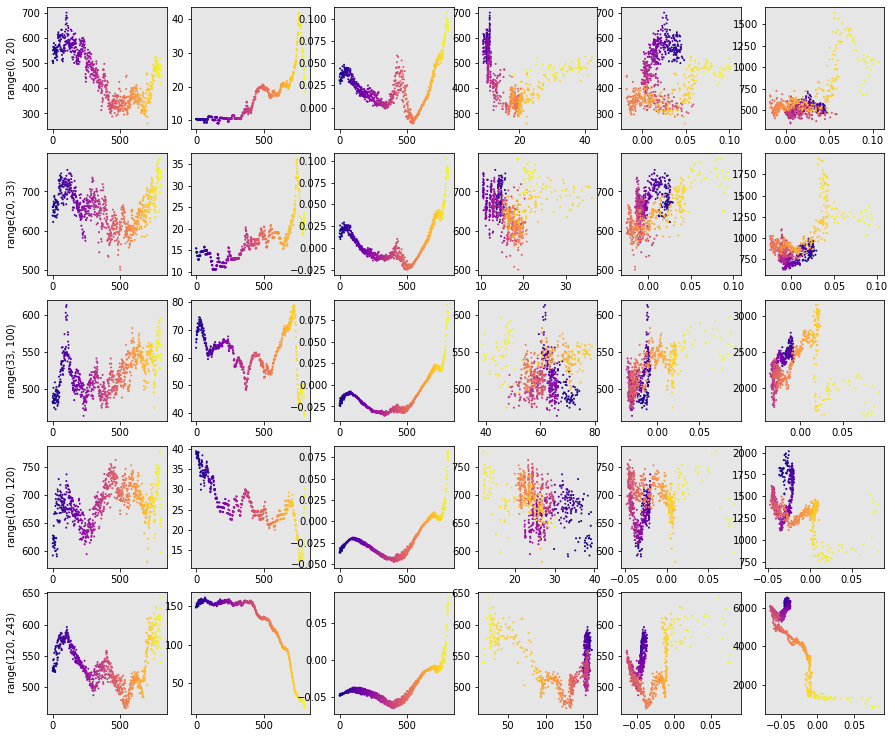

In [270]:
crown_idx = layer4_mean_local_flux.argmin()
crown_idx = 0
fig_column = 6
plt.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
fig = plt.figure(figsize=(2.5*fig_column,2.6*len(layers)))
# corr1 = []
# corr2 = []
my_size = len(seed_choice[crown_idx:])
for i, idx in enumerate(layers):
    fig.add_subplot(len(layers),fig_column,fig_column*i+1)
    plt.scatter(np.arange(my_size), mean_cell_density[i,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    plt.ylabel(idx)
    fig.add_subplot(len(layers),fig_column,fig_column*i+2)
    plt.scatter(np.arange(my_size), layer_thickness[i,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+3)
    plt.scatter(np.arange(my_size), mean_local_flux[i,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+4)
    plt.scatter(layer_thickness[i,crown_idx:], mean_cell_density[i,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+5)
    plt.scatter(mean_local_flux[i,crown_idx:], mean_cell_density[i,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    # corr1.append(pearsonr(layer_thickness[i,selection], mean_cell_density[i,selection]))
    # corr2.append(pearsonr(mean_local_flux[i,selection], mean_cell_density[i,selection]))
    fig.add_subplot(len(layers),fig_column,fig_column*i+6)
    plt.scatter(mean_local_flux[i,crown_idx:], layer_cell_count[i,:],s=1,c=np.arange(len(seed_choice)),cmap='plasma')


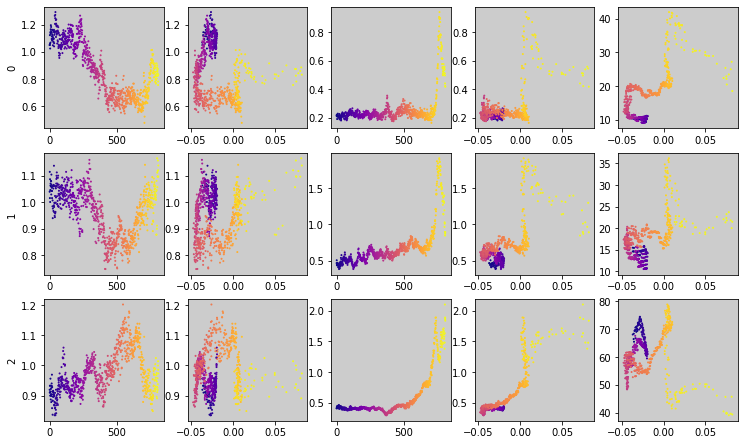

In [507]:
crown_idx = layer4_mean_local_flux.argmin()
crown_idx = 0
fig_column = 6
plt.rcParams['axes.facecolor'] = [0.8,0.8,0.8]
fig = plt.figure(figsize=(2.5*fig_column,2.6*len(layers)))
my_size = len(seed_choice[crown_idx:])
for i in range(3):
    fig.add_subplot(len(layers),fig_column,fig_column*i+1)
    plt.scatter(np.arange(my_size), mean_cell_density[i,crown_idx:]/mean_cell_density[i+2,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    plt.ylabel(i)
    fig.add_subplot(len(layers),fig_column,fig_column*i+2)
    plt.scatter(layer4_mean_local_flux[crown_idx:], mean_cell_density[i,crown_idx:]/mean_cell_density[i+2,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    # layer_cell_count
    fig.add_subplot(len(layers),fig_column,fig_column*i+3)
    plt.scatter(np.arange(my_size), layer_cell_count[i,crown_idx:]/layer_cell_count[i+2,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+4)
    #plt.scatter(layer4_mean_local_flux[crown_idx:], layer_cell_count[i,crown_idx:]/layer_cell_count[i+2,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    plt.scatter(layer4_mean_local_flux, layer_cell_count[i,:]/layer_cell_count[i+2,:],s=1,c=np.arange(layer4_mean_local_flux.size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+5)
    plt.scatter(layer4_mean_local_flux[crown_idx:], layer_thickness[i,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    # corr1.append(pearsonr(layer_thickness[i,selection], mean_cell_density[i,selection]))
    # corr2.append(pearsonr(mean_local_flux[i,selection], mean_cell_density[i,selection]))
    # fig.add_subplot(len(layers),fig_column,fig_column*i+6)
    # plt.scatter(np.arange(len(seed_choice)), mean_cell_density[i,:],s=1,c=np.arange(len(seed_choice)),cmap='plasma')


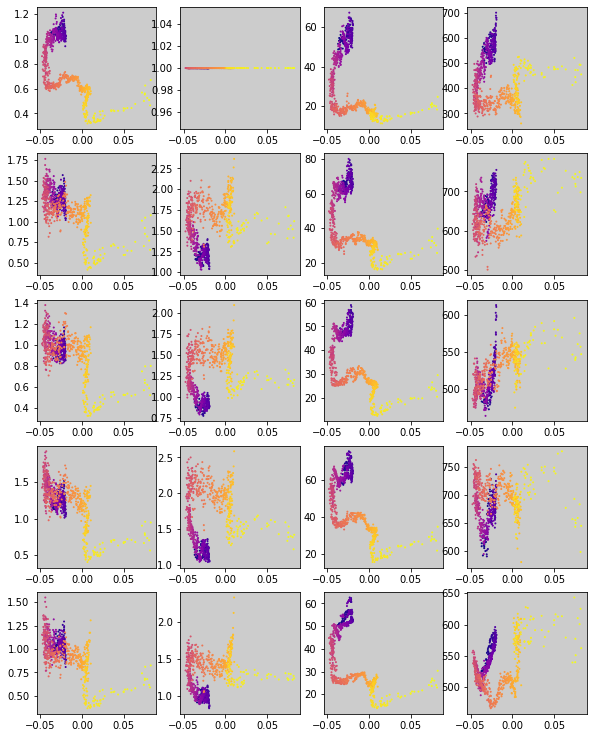

In [309]:
crown_idx = (layer4_mean_local_flux!=0)
fig_column = 6
plt.rcParams['axes.facecolor'] = [0.8,0.8,0.8]
fig = plt.figure(figsize=(2.5*fig_column,2.6*len(layers)))
my_size = crown_idx.sum()
for i in range(5):
    fig.add_subplot(len(layers),fig_column,fig_column*i+1)
    plt.scatter(layer4_mean_local_flux[crown_idx], mean_cell_density[i,crown_idx]/layer_cell_count[0,crown_idx],s=1,c=np.arange(my_size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+2)
    plt.scatter(layer4_mean_local_flux[crown_idx], mean_cell_density[i,crown_idx]/mean_cell_density[0,crown_idx],s=1,c=np.arange(my_size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+3)
    plt.scatter(layer4_mean_local_flux[crown_idx], mean_cell_density[i,crown_idx]/layer_thickness[0,crown_idx],s=1,c=np.arange(my_size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+4)
    plt.scatter(layer4_mean_local_flux[crown_idx], mean_cell_density[i,crown_idx],s=1,c=np.arange(my_size),cmap='plasma')

    # corr1.append(pearsonr(layer_thickness[i,selection], mean_cell_density[i,selection]))
    # corr2.append(pearsonr(mean_local_flux[i,selection], mean_cell_density[i,selection]))
    # fig.add_subplot(len(layers),fig_column,fig_column*i+6)
    # plt.scatter(np.arange(len(seed_choice)), mean_cell_density[i,:],s=1,c=np.arange(len(seed_choice)),cmap='plasma')


In [376]:
def line_wise_aligner(std, target, initial_displacement, settings):
    displacement = np.zeros_like(target)
    f = interpolate.interp1d(np.arange(std.size), std, bounds_error=False, fill_value='extrapolate')

    for line in tqdm(range(target.shape[1])):
        # load initial_displacement
        shift = initial_displacement[:,line]
        
        # initial transform for the registration
        std_shift = f(np.arange(shift.size)-shift)

        # run pydeform line by line
        target_np = target[:,line]
        
        # convert to itk image for registration
        fix_l_itk = sitk.Cast(sitk.GetImageFromArray(target_np[:, np.newaxis, np.newaxis]),sitk.sitkFloat32)
        mov_l_itk = sitk.Cast(sitk.GetImageFromArray(std_shift[:, np.newaxis, np.newaxis]),sitk.sitkFloat32)

        df_sitk = pydeform.register(
            fix_l_itk,
            mov_l_itk,
            settings=settings,
            num_threads=60,
            use_gpu=True
        )

        pos = sitk.GetArrayFromImage(df_sitk)[:,0,0,2]
        displacement[:,line] = pos - shift
        coords = np.meshgrid(*[range(x) for x in displacement.shape], indexing='ij')
        coords = np.array(coords).astype(np.int16)
        target2standard = coords[0,:,:]-displacement
        standard2target = coords[0,:,:]+displacement

    return target2standard, standard2target

In [508]:
# fonus analysis in crown 
seed_choice = seeds_df.index[seeds_df.iloc[:,4:].all(axis=1)].to_list()
#seed_choice = seeds_df[cond1*cond2].index.to_list()
# reduce dimention to 1d for manual alignment
X0_selected = seeds_df.iloc[:,0:3].loc[seed_choice,:]
iso1d = manifold.Isomap(n_neighbors=20, n_components=1, n_jobs=-1) # change n_neighbors in case of error.
iso1d.fit(X0_selected)
manifold_1D_ver2 = iso1d.transform(X0_selected)
manifold_1D_ver2_df = pd.DataFrame(manifold_1D_ver2,index=seed_choice)
seed_choice = manifold_1D_ver2_df.sort_values(0).index.to_list()

In [621]:
target_df = column_conv.reindex(seed_choice)
target = column_conv.reindex(seed_choice).to_numpy().T
viewer0 = napari.Viewer()
viewer0.add_image(target, rgb=False, name='original', colormap='gray', blending='additive', multiscale=False)

<Image layer 'original' at 0x7f397d4391f0>

In [622]:
# std_idx = 596
# std_seed = seed_choice[std_idx]# dprime is done with std_seed 5582
# std_values = column_conv.loc[std_seed].to_numpy()

standard = np.repeat(std_values[:,np.newaxis],len(seed_choice),axis=1)
viewer0.add_image(standard, rgb=False, name='std', colormap='gray', blending='additive', multiscale=False)
# manually label layer IV for the flux calculation.
# based on the flux, choose gyrus-bank area
labels = viewer0.add_labels(np.zeros_like(standard.astype(int)), name='labeling')

In [623]:
# make initial displacement using manual labels.
labels_np = labels.data

initial_displacement = np.zeros_like(standard)

std_landmark = np.array([0,28,120,253,standard.shape[0]-1,standard.shape[0]]) # these are fixed numbers.
# target_landmarks = [] 
for line in range(standard.shape[1]):
    # make landmarks_fix
    landmark = std_landmark.copy()
    for i in range(1, std_landmark.size-1):
        positions = np.where(labels_np[:,line]==i)[0]
        if positions.size != 0:
            landmark[i] = round(positions.mean())
        else:
            landmark[i] = std_landmark[i]
    # make manually generated position shift
    shift = interpolate.griddata(std_landmark,landmark-std_landmark,xi=coord,method='linear') # cubic distort the thing...
    initial_displacement[:,line] = shift

In [624]:
# set parameters
settings = {
    'pyramid_levels':1, # larger number can deteriorate the initial alignment.
    'pyramid_stop_level': 0, # 1 is good. 2 is just enough, 3 is not enough.
    'step_size': [0.2, 0.2, 0.2], # [1.0,1.0,1.0] seems enough. more than that will degrade the quality
    'block_size': [0,0,0],
    'block_energy_epsilon':1e-7,
    'max_iteration_count':100,
    'constraints_weight':1000.0,
    'regularization_weight': 0.25, # default 0.25
    'regularization_scale': 1.0, # default 1.0
    'regularization_exponent': 2.0, # default 2.0
    'image_slots':[{
            'resampler': 'gaussian',
            'normalize': True,
            'cost_function':[
                {
                    'function':'ncc',
                    'weight':1.0,
                    'radius':15
                }
            ]
        }]
}

In [625]:
#my_choice = np.r_[-300:len(seed_choice)]
my_choice = list(range(0,len(seed_choice)))#list(range(100,150)) + list(range(-300,-1))

In [626]:
target2standard_ver2, standard2target_ver2 = line_wise_aligner(std_values, target[:,my_choice], initial_displacement[:,my_choice], settings)
# target2standard_ver2, standard2target_ver2 = line_wise_aligner(std_values, target[:,-300:], np.zeros_like(initial_displacement[:,-300:]), settings)
# pd.DataFrame(target2standard_ver2.T,index=seed_choice).to_csv('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis/linewise_aligned.csv')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6699/6699 [1:51:10<00:00,  1.00it/s]


In [627]:
target2standard_ver2_df = pd.DataFrame(target2standard_ver2.T,index=seed_choice)
standard2target_ver2_df = pd.DataFrame(standard2target_ver2.T,index=seed_choice)

In [629]:
viewer = napari.Viewer()
viewer.add_image(np.diff(target2standard_ver2,axis=0), contrast_limits=[-0.1,0], rgb=False, name='tgt2std', colormap='gray', blending='additive', multiscale=False)
viewer.add_image(target2standard_ver2, rgb=False, name='tgt2std', colormap='gray', blending='additive', multiscale=False)

<Image layer 'tgt2std [1]' at 0x7f39786595e0>

In [630]:
aligned_ver2 = map_coordinates(target[:,my_choice], make_displacement_map(target2standard_ver2), order=1, mode='constant')
aligned_ver2_df = pd.DataFrame(aligned_ver2.T,index=seed_choice)
aligned_standard_ver2 = map_coordinates(standard[:,my_choice], make_displacement_map(standard2target_ver2), order=1, mode='constant')
viewer = napari.Viewer()
viewer.add_image(target[:,my_choice], rgb=False, name='original', colormap='green', blending='additive', multiscale=False)
viewer.add_image(aligned_ver2, rgb=False, name='deform', colormap='magenta', blending='additive', multiscale=False)
viewer.add_image(standard[:,my_choice], rgb=False, name='standard', colormap='gray', blending='additive', multiscale=False)
viewer.add_image(aligned_standard_ver2, rgb=False, name='standard', colormap='gray', blending='additive', multiscale=False)

<Image layer 'standard [1]' at 0x7f39783b9610>

In [797]:
# local flux map
local_flux = []
for i, seed_num in tqdm(list(enumerate(seed_choice))):
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    # append positions to be consisntent in size.
    positions = np.pad(positions,[(0,501-positions.shape[0]),(0,0)],mode='edge')
    # get local flux
    local_flux.append(get_local_flux(positions, norm_flow_on_coordinate, radius))
    
local_flux_df = pd.DataFrame(np.vstack(local_flux),index=seed_choice)

aligned_local_flux = map_coordinates(np.vstack(local_flux).T, make_displacement_map(target2standard_ver2_df.reindex(seed_choice).T), order=1, mode='constant')
aligned_local_flux_df = pd.DataFrame(aligned_local_flux.T, index=seed_choice)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6699/6699 [00:24<00:00, 270.79it/s]


In [798]:
# ask layer mean cell density and thickness 

half_thickness = 2.5
radius = 10
layer_cell_count = []
layer_thickness = []

for seed_num in tqdm(seed_choice):
    # get positions and flows
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    flow = norm_flow_on_coordinate(positions) # flow is normalized
    
    dist = position2distance(positions)
    dprime = target2standard_ver2_df.loc[seed_num,:]
    cell_number_list = []
    thickness = []
    for layer in layers:
        # get range of layers
        eval_range = dprime[layer]
        eval_range = range(round(eval_range.min()),round(eval_range.max()))
        # count cell number
        _, idx, _ = conv_along_line(half_thickness, positions[eval_range], flow[eval_range], coords_tree, radius, time_end+1)
        cell_number_list.append(get_unique_number(idx).size)
        # measure thickness
        thickness.append(dist[eval_range].sum())
    layer_cell_count.append(np.asarray(cell_number_list))
    layer_thickness.append(np.asarray(thickness))
    
layer_cell_count = np.vstack(layer_cell_count).T
layer_cell_count_df = pd.DataFrame(layer_cell_count.T,index=seed_choice) # layer_cell_count_df = pd.DataFrame(layer_cell_count.T,index=seed_choice[:layer_cell_count.shape[1]])
layer_thickness = np.vstack(layer_thickness).T
layer_thickness_df = pd.DataFrame(layer_thickness.T,index=seed_choice) # layer_thickness_df = pd.DataFrame(layer_thickness.T,index=seed_choice[:layer_thickness.shape[1]])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6699/6699 [03:46<00:00, 29.64it/s]


In [891]:
# these are not accurate. but close.
layer_cell_density = []
layer_local_flux = []
for layer in layers:
    layer_cell_density.append(aligned_ver2[layer,:].mean(axis=0))
    layer_local_flux.append(aligned_local_flux[layer,:].mean(axis=0))

layer_cell_density = np.vstack(layer_cell_density) 
layer_cell_density_df = pd.DataFrame(layer_cell_density.T,index=seed_choice)
layer_cell_density = layer_cell_density_df.to_numpy().T

layer_local_flux = np.vstack(layer_local_flux)
layer_local_flux_df = pd.DataFrame(layer_local_flux.T,index=seed_choice)
layer4_local_flux = layer_local_flux[3,:]


In [695]:
# # redefine isomap for better visualization
# X0_selected = seeds_df.iloc[:,0:3].loc[my_choice,:]
# iso1d = manifold.Isomap(n_neighbors=10, n_components=1, n_jobs=-1) # change n_neighbors in case of error.
# iso1d.fit(X0_selected)
# manifold_1d_ver3 = iso1d.transform(X0_selected)
# manifold_1d_ver3_df = pd.DataFrame(manifold_1d_ver3,index=my_choice)
# my_sort = manifold_1d_ver3_df.sort_values(0).index.to_list()

In [696]:
# # visualize the label in 3D with color

# points_vis = seeds_df.iloc[:,0:3].reindex(my_sort)
# color_vis = color.get_colormap('plasma').map(np.arange(points_vis.shape[0]) / points_vis.shape[0])
# viewer = napari.Viewer()
# points = viewer.add_points(
#     points_vis,
#     size=10,
#     face_color = color_vis,
#     edge_width=0,
#     symbol='disc',
# )
# viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray', blending='translucent', multiscale=False)
# viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f3972f4c3d0>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6699/6699 [00:01<00:00, 3645.63it/s]


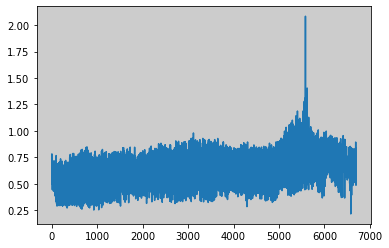

In [872]:
# remove seeds with low quality
mi = []
# dtws = [] # dtw and cosine similarity is almost same
cos_sim = []
for i in tqdm(list(range(aligned_ver2.shape[1]))):
    mi.append(mutual_information(std_values, aligned_ver2[:,i], bins=10))
    # dtws.append(dtw(std_values, aligned_ver2[:,i]))
    cos_sim.append(cosine_similarity(std_values, aligned_ver2[:,i]))
mi = np.asarray(mi)
# dtws = np.asarray(dtws)
cos_sim = np.asarray(cos_sim)


plt.plot(mi)

In [1397]:
# print(np.percentile(mi,50))
# print(np.percentile(cos_sim,50))

4313

0.6273109903903874
0.7670435176437579
1497


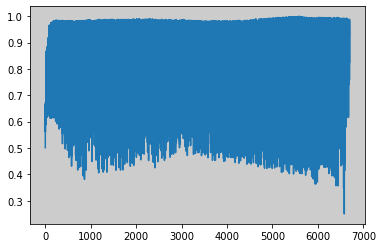

In [1419]:
# metrics = np.vstack([mi,cos_sim])
# metrics = zscore(metrics,axis=1)
# sns.clustermap(metrics, row_cluster=False)
th1 = threshold_otsu(mi)#np.percentile(mi,50)
th2 = threshold_otsu(cos_sim)#np.percentile(cos_sim,50)
print(th1)
print(th2)
plt.plot(cos_sim)
my_choice = np.asarray(seed_choice)[(mi>th1)*(cos_sim>th2)].tolist()
print(len(my_choice))

In [1440]:
# find 3D coordinate and map back into the 3D image for better visualization. Quality check
pos_img = np.zeros_like(asma_downscale)
for i, seed_num in enumerate(my_choice):
    virtual_rg = virtual_rgs[seed_num]
    positional_displacement = standard2target_ver2_df.loc[seed_num].to_numpy()
    positional_displacement[positional_displacement<0]=0 # clipping

    positions = virtual_rg.trajectory.ode_solution.y

    positional_displacement = positional_displacement[:positions.shape[1]]
    pos_img[tuple(positions.astype(int))] = positional_displacement
    
pos_img = pos_img * segmented_tissue.astype(np.uint16)
viewer = napari.Viewer()
viewer.add_image(pos_img, contrast_limits=[0,501], rgb=False, name='flow', colormap=turbo_dark, blending='additive', multiscale=False)
viewer.add_image(autofl, contrast_limits=[0,5000], rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False, visible=False)


points_vis = seeds_df.iloc[:,0:3].reindex(my_choice)
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = 'white',
    edge_width=0,
    symbol='disc',
)

viewer2 = napari.Viewer()
viewer2.add_image(aligned_ver2_df.reindex(my_choice).to_numpy().T, rgb=False, name='aligned', colormap=turbo_dark, blending='additive', multiscale=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'aligned' at 0x7f356ef1f670>

[0.24013176 0.12114869 0.09221766 0.08084641 0.04541628 0.0447428
 0.03277949 0.03035387 0.02474309 0.01790013]
0.7302801679069882


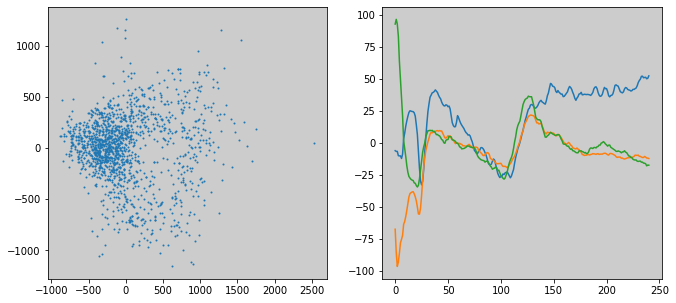

In [1673]:
# Can I do PCA/tSNE to the aligned space?
# However, pca only indicates how far from edge. It is an artifact and not biological.
from sklearn.decomposition import PCA

trim = 240
aligned_trimmed = aligned_ver2_df.loc[:,:trim].reindex(my_choice)
aligned_trimmed_zscore = zscore(aligned_trimmed,axis=0)
pca = PCA().fit(aligned_trimmed)
pcs = pca.transform(aligned_trimmed)
pc1 = pcs[:,0]
pc2 = pcs[:,1]

fig, axs = plt.subplots(ncols=2, figsize=(11,5))
axs[0].scatter(pc1,pc2,s=1)
#print(pca.explained_variance_ratio_)

component_num = 10
print(pca.explained_variance_ratio_[:component_num])
print(pca.explained_variance_ratio_[:component_num].sum())
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# fig, axs = plt.subplots(ncols=1, figsize=(5,5))
axs[1].plot(loadings[:,0])
axs[1].plot(loadings[:,1])
axs[1].plot(loadings[:,2])

# viewer = napari.Viewer()

# viewer.add_image(aligned_trimmed.T.to_numpy(), rgb=False, name='aligned', colormap='viridis', blending='additive', multiscale=False)
# viewer.add_image(zscore(aligned_trimmed.T.to_numpy(),axis=1), rgb=False, name='zscore', colormap='viridis', blending='additive', multiscale=False)

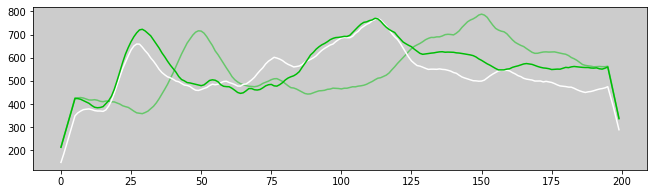

In [1670]:
fig, axs = plt.subplots(ncols=1, figsize=(11,3))
my_pos = 7
axs.plot(moving_average(target_df.reindex(my_choice).to_numpy().T[:200,my_pos]),c='#67c76b')
axs.plot(moving_average(std_values[:200]), c='white')
axs.plot(moving_average(aligned_ver2_df.reindex(my_choice).to_numpy().T[:200,my_pos]),c='#00bd06')
plt.savefig("/home/tmurakami/src/misc_notebooks/human_nucleus_analysis/alignment_example.svg")

(0.6667019272252168, 4.431813768980088e-193)
(-0.01442049458292843, 0.577180741041842)
(0.15382005887249928, 2.202411178354008e-09)


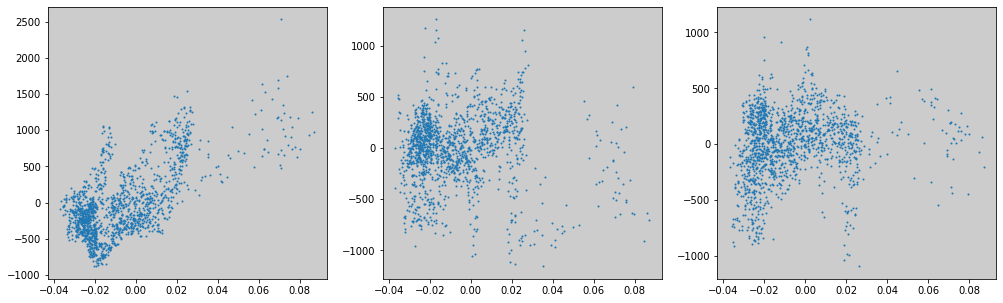

In [1469]:
fig, axs = plt.subplots(ncols=3, figsize=(17,5))
layer4_flux = layer_local_flux_df.reindex(my_choice).loc[:,2]

for i in range(3):
    axs[i].scatter(layer4_flux,pcs[:,i],s=1)

# sns.displot(pd.DataFrame(np.vstack([layer4_flux,pc1]).T),x=0,y=1, kind="kde",thresh=0.01)
print(pearsonr(layer4_flux,pcs[:,0]))
print(pearsonr(layer4_flux,pcs[:,1]))
print(pearsonr(layer4_flux,pcs[:,2]))
# plt.savefig("/home/tmurakami/src/misc_notebooks/human_nucleus_analysis/pc1_local_flux_layer3.svg")

In [1682]:
# visualize the label in 3D with color

points_vis = seeds_df.iloc[:,0:3].reindex(my_choice)
viewer = napari.Viewer()

color_vis = color.get_colormap('viridis').map((pc1-np.percentile(pc1,2)) / (np.percentile(pc1,98)-np.percentile(pc1,2)))#((pc1-pc1.min()) / (pc1.max()-pc1.min()))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
color_vis = color.get_colormap('viridis').map((pc2-np.percentile(pc2,2)) / (np.percentile(pc2,98)-np.percentile(pc2,2)))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
color_vis = color.get_colormap('viridis').map((layer4_flux-np.percentile(layer4_flux,2)) / (np.percentile(layer4_flux,98)-np.percentile(layer4_flux,2)))#((layer4_flux-layer4_flux.min()) / (layer4_flux.max()-layer4_flux.min()))
#color_vis = color.get_colormap('viridis').map((layer4_flux-np.min(layer4_flux)) / (np.max(layer4_flux)-np.min(layer4_flux)))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)

viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray', blending='translucent', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,100000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f3498fa0c10>

In [1489]:
# define function to calculate variable importance in projection
# https://github.com/scikit-learn/scikit-learn/issues/7050
def vip(x, y, model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

In [1504]:
# suppose the density is largely affected by divergence,
# how each positions of line are affected by divergence. test this with PLS.
# also read this. http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html
from sklearn.cross_decomposition import PLSRegression
from sklearn import model_selection

kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, aligned_trimmed_zscore, layer4_flux, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)
pls2 = PLSRegression(n_components=np.argmin(mse)).fit(aligned_trimmed_zscore,layer4_flux)

(0.0, 1.8)

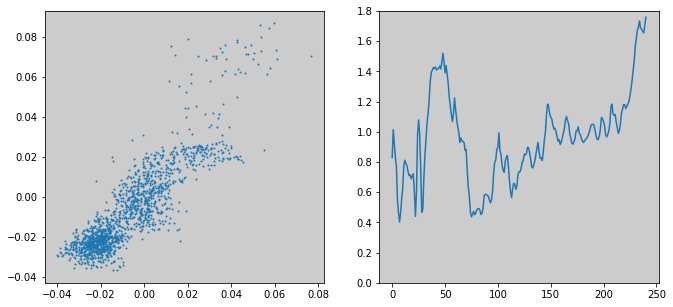

In [1681]:
fig, axs = plt.subplots(ncols=2, figsize=(11,5))
axs[0].scatter(pls2.predict(aligned_trimmed_zscore),layer4_flux,s=1)
axs[1].plot(vip(aligned_trimmed_zscore,layer4_flux,pls2))
axs[1].set_ylim([0, 1.8])
# fig, axs = plt.subplots(ncols=1, figsize=(11,3))
# axs.plot(vip(aligned_trimmed_zscore,layer4_flux,pls2))
# axs.set_ylim([0, 1.8])
# plt.savefig("/home/tmurakami/src/misc_notebooks/human_nucleus_analysis/vip_anlaysis_layer.svg")

In [1655]:
viewer = napari.Viewer()
viewer.add_image(aligned_trimmed.T.to_numpy(), rgb=False, name='aligned', colormap='magma', blending='additive', multiscale=False)
viewer.add_image(aligned_trimmed_zscore.T.to_numpy(), rgb=False, name='zscoreall', colormap='magma', blending='additive', multiscale=False)
viewer.add_image(target_df.reindex(my_choice).to_numpy().T, rgb=False, name='original', colormap='gray', blending='additive', multiscale=False)
# viewer.add_image(aligned_trimmed_zscore.T.to_numpy()[33:56,100:], rgb=False, name='zscoreall', colormap='magma', blending='additive', multiscale=False)
# viewer.add_image(aligned_trimmed_zscore.T.to_numpy()[77:100,100:], rgb=False, name='zscoreall', colormap='magma', blending='additive', multiscale=False)
# viewer.add_image(aligned_trimmed_zscore.T.to_numpy()[220:243,100:], rgb=False, name='zscoreall', colormap='magma', blending='additive', multiscale=False)

<Image layer 'original' at 0x7f34d0ff5b80>

In [1553]:
# how much can I reduce the variance by analysing in my way?
# get bin and divide flux into 10 ranges
# measure SD in each range. SD of 
bin_num = 10
my_bin = np.arange(layer4_flux.min(),layer4_flux.max(),(layer4_flux.max()-layer4_flux.min())/bin_num)
idx = np.digitize(layer4_flux,my_bin)
idx_df = pd.DataFrame(idx,index=my_choice)
sum_count = []
for seed_num in my_choice:
    #tes = target_df.reindex(my_choice)[idx==i]
    cell_count = target_df.loc[seed_num,:]
    loc = round(standard2target_ver2_df.loc[seed_num,:].iloc[layer4[-1]])
    sum_count.append(cell_count.iloc[:loc].sum())
sum_count_df = pd.DataFrame(sum_count,index=my_choice)

In [1564]:
sd_percent = []
for i in range(1,idx.max()+1):
    sd = np.std(sum_count_df[idx==i].to_numpy())
    sd_percent.append(sd/sum_count_df[idx==i].mean().values)
    #sd_list.append()
sd_percent

[array([0.08312438]),
 array([0.12592723]),
 array([0.10199797]),
 array([0.11102986]),
 array([0.07035193]),
 array([0.10140826]),
 array([0.05348969]),
 array([0.13829879]),
 array([0.12956897]),
 array([0.10453193])]

In [1590]:
viewer = napari.Viewer()
viewer.add_image(aligned_ver2_df.reindex(my_choice).T.to_numpy()[:300,620:1310], rgb=False, name='aligned', colormap='viridis', blending='additive', multiscale=False)
#viewer.add_image(aligned_trimmed_zscore.T.to_numpy(), rgb=False, name='zscoreall', colormap='viridis', blending='additive', multiscale=False)
viewer.add_image(target_df.reindex(my_choice).to_numpy().T[:300,620:1310], rgb=False, name='original', colormap='gray', blending='additive', multiscale=False)
#viewer.add_image(aligned_trimmed_zscore.T.to_numpy()[:,::4], rgb=False, name='zscore_skipped', colormap='viridis', blending='additive', multiscale=False)


<Image layer 'original' at 0x7f35475aa250>

In [1698]:
# can I estimate radial glial density with aSMA?
skeleton = np.load(os.path.join(io_directory,'skeleton.npy'))

In [1716]:
viewer = napari.Viewer()

viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray', blending='translucent', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,100000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)
viewer.add_image(asma_downscale*(~tes), contrast_limits=[0,100000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)
viewer.add_image(skeleton, rgb=False, name='skeleton', colormap='yellow', blending='additive', multiscale=False,visible=False)
#viewer.add_image(skeleton*(~tes), contrast_limits=[0,50],rgb=False, name='segment', colormap='yellow', blending='additive', multiscale=False,visible=False)


<Image layer 'skeleton' at 0x7f3489dd8340>

In [1282]:
'''DBSCAN did not work because it connects all the population...'''
# # should I take into account the spatial information or clustering?
# # https://stackoverflow.com/questions/66406003/clustering-geospatial-data-on-coordinates-and-non-spatial-feature
# # how about getting pairwise mutual information?
# # both in before and after alignment.
# # before alignment. the length of vectors are adjusted to be same by simply cutting off the longer one.
# standard_end_pos = 300
# combination_mi_df = pd.DataFrame(columns=my_choice,index=my_choice)
# for s1, s2 in tqdm(list(itertools.combinations(my_choice,2))):
#     end_pos1 = round(standard2target_ver2_df.loc[s1,standard_end_pos])
#     end_pos2 = round(standard2target_ver2_df.loc[s2,standard_end_pos])
#     end_pos = np.min([end_pos1,end_pos2])
#     vec1 = target_df.loc[s1,:].to_numpy()[:end_pos]
#     vec2 = target_df.loc[s2,:].to_numpy()[:end_pos]
#     combination_mi_df.loc[s1,s2] = mutual_information(vec1, vec2, bins=10)
#     combination_mi_df.loc[s2,s1] = combination_mi_df.loc[s1,s2]
# # to fill diagonal
# for s in my_choice:
#     end_pos = round(standard2target_ver2_df.loc[s,standard_end_pos])
#     vec = target_df.loc[s,:].to_numpy()[:end_pos]
#     combination_mi_df.loc[s,s] = mutual_information(vec, vec, bins=10)
    
# # cosine similarity ver
# # before alignment. the length of vectors are adjusted to be same by simply cutting off the longer one.
# standard_end_pos = 300
# combination_cs_df = pd.DataFrame(columns=my_choice,index=my_choice,dtype=float)
# for s1, s2 in tqdm(list(itertools.combinations(my_choice,2))):
#     end_pos1 = round(standard2target_ver2_df.loc[s1,standard_end_pos])
#     end_pos2 = round(standard2target_ver2_df.loc[s2,standard_end_pos])
#     end_pos = np.min([end_pos1,end_pos2])
#     vec1 = target_df.loc[s1,:].to_numpy()[:end_pos]
#     vec2 = target_df.loc[s2,:].to_numpy()[:end_pos]
#     combination_cs_df.loc[s1,s2] = cosine_similarity(vec1, vec2)
#     combination_cs_df.loc[s2,s1] = combination_cs_df.loc[s1,s2]
# # to fill diagonal
# for s in my_choice:
#     end_pos = round(standard2target_ver2_df.loc[s,standard_end_pos])
#     vec = target_df.loc[s,:].to_numpy()[:end_pos]
#     combination_cs_df.loc[s,s] = cosine_similarity(vec, vec)
    
# # after alignment. 
# combination_mi_aligned_df = pd.DataFrame(columns=my_choice,index=my_choice, dtype=float)
# for s1, s2 in tqdm(list(itertools.combinations(my_choice,2))):
#     vec1 = aligned_ver2_df.loc[s1,:].to_numpy()[:standard_end_pos]
#     vec2 = aligned_ver2_df.loc[s2,:].to_numpy()[:standard_end_pos]
#     combination_mi_aligned_df.loc[s1,s2] = mutual_information(vec1, vec2, bins=10)
#     combination_mi_aligned_df.loc[s2,s1] = combination_mi_aligned_df.loc[s1,s2]

# # to fill diagonal
# for s in my_choice:
#     vec = aligned_ver2_df.loc[s,:].to_numpy()[:standard_end_pos]
#     combination_mi_aligned_df.loc[s,s] = mutual_information(vec, vec, bins=10)
    
# # DBSCAN using mutual information
# import hdbscan
# db = hdbscan.HDBSCAN(metric='precomputed',min_cluster_size=6)
# clusterer = db.fit((1/combination_cs_df-1).to_numpy())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1119756/1119756 [11:04<00:00, 1685.16it/s]


In [1604]:
values = []

for i in range(4):
    #val = layer_cell_count[i,:]/layer_cell_count[i+1,:] #metric_of_choice
    val = np.log10(layer_cell_count[i,:]) - np.log10(layer_cell_count[i+1,:])
    # val = layer_cell_count_df.reindex(my_choice).to_numpy().T[i,:]/layer_cell_count_df.reindex(my_choice).to_numpy().T[i+1,:]
    # plow = np.percentile(val,15)
    # phigh = np.percentile(val,85)
    
    # val[val<plow] = plow
    # val[val>phigh] = phigh
    
    #values.append((val - np.median(val)) / (phigh - plow))
    values.append(val)
val_df = pd.DataFrame(np.vstack(values).T,index=seed_choice)
val_df = val_df.reindex(my_choice)

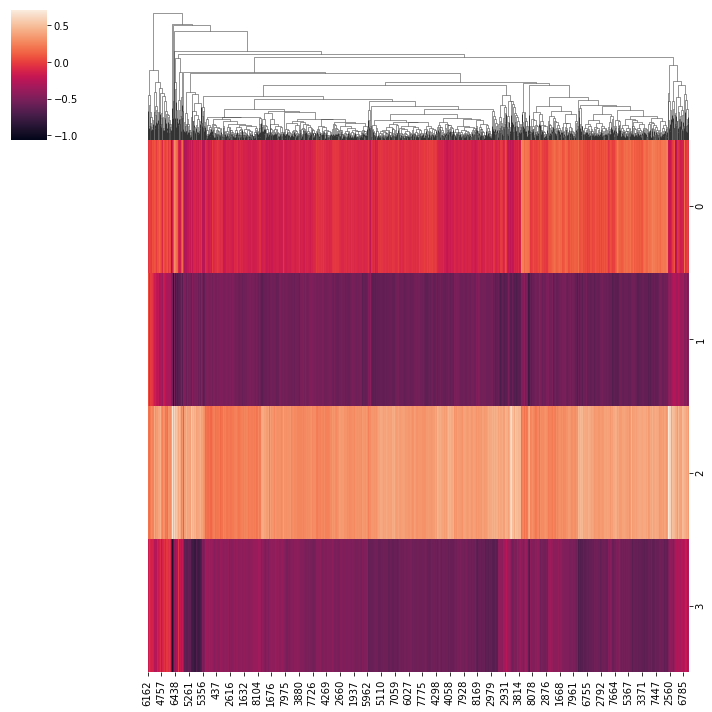

In [1605]:
import seaborn as sns
#from scipy.stats import zscore
from sklearn.cluster import AgglomerativeClustering

# my_mtx = val_df.reindex(my_choice).T
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward').fit(val_df)
label = cluster.labels_
# heatmap should look boring. This is the sampling highly biased onto the region with higher surface area
sns.clustermap(val_df.T, row_cluster=False)
label_df = pd.Series(label,index=my_choice)

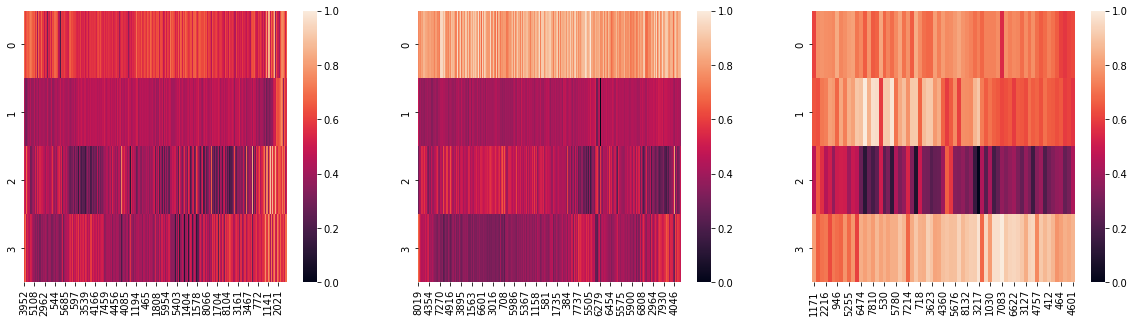

In [1606]:
_, freq = np.unique(label, return_counts=True)
val_df_norm = (val_df - val_df.min(axis=0)) / (val_df.max(axis=0) - val_df.min(axis=0))

fig, axs = plt.subplots(ncols=label.max()+1, figsize=(20,5))
for i in range(label.max()+1):
    sns.heatmap(val_df_norm[label==np.argsort(freq)[-i-1]].T,ax=axs[i],vmin=0.0,vmax=1.0)

In [1126]:
# tes = val_df.groupby(label).sample(n=freq.min())

In [1614]:
# do pca to extract "gyrus-ness"
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(val_df)
pcs = pca.transform(val_df)
pc1 = pcs[:,0]
pc2 = pcs[:,1]
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.46164911 0.2953492  0.12824598 0.11475571]
1.0


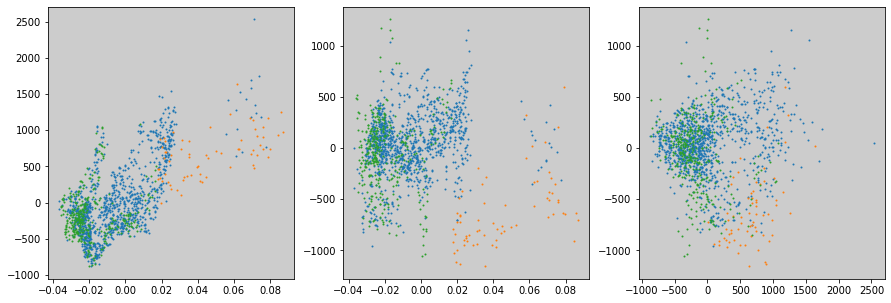

In [1720]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
layer4_flux = layer_local_flux_df.reindex(my_choice).loc[:,2]
for i in range(label.max()+1):
    axs[0].scatter(layer4_flux[label==i],pc1[label==i],s=1)
    axs[1].scatter(layer4_flux[label==i],pc2[label==i],s=1)
    axs[2].scatter(pc1[label==i],pc2[label==i],s=1)

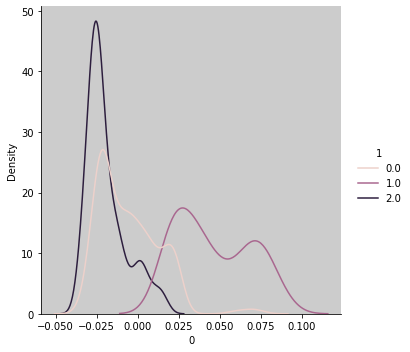

In [1230]:
sns.displot(pd.DataFrame(np.vstack([layer4_flux,label]).T),x=0,hue=1, kind="kde",common_norm=False,hue_order=(0,1,3,5,2,4))

In [1612]:
# visualize the label in 3D with color

points_vis = seeds_df.iloc[:,0:3].reindex(my_choice)
viewer = napari.Viewer()

#('viridis').map((pc1-np.percentile(pc1,2)) / (np.percentile(pc1,98)-np.percentile(pc1,2)))
# color_vis = color.get_colormap('viridis').map((label-label.min()) / (label.max()-label.min()))
# points = viewer.add_points(
#     points_vis,
#     size=10,
#     face_color = color_vis,
#     edge_width=0,
#     symbol='disc',
# )

color_vis = color.get_colormap('viridis').map((pc1-np.percentile(pc1,2)) / (np.percentile(pc1,98)-np.percentile(pc1,2)))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
color_vis = color.get_colormap('viridis').map((pc2-np.percentile(pc2,2)) / (np.percentile(pc2,98)-np.percentile(pc2,2)))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
color_vis = color.get_colormap('viridis').map((layer4_flux-np.percentile(layer4_flux,2)) / (np.percentile(layer4_flux,98)-np.percentile(layer4_flux,2)))#(layer4_flux-layer4_flux.min()) / (layer4_flux.max()-layer4_flux.min()))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)

viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray', blending='translucent', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f3438418bb0>

In [1159]:
viewer = napari.Viewer()
shift = -100

for i in range(label_df.max()+1):
    my_tes = aligned_ver2_df.reindex(label_df[label_df==i].index)
    #my_tes = zscore(((my_tes) - (np.roll(my_tes,shift,axis=0))),axis=0)
    viewer.add_image(my_tes.to_numpy().T, rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False) # ((my_tes) - (np.roll(my_tes,shift,axis=0)))